In [1]:

import numpy as np
import matplotlib.pyplot as plt
import time
import random
from mpmath import mp, matrix, eye
import math

In [2]:
def set_precision(dps):
    mp.dps = dps


In [3]:
def mp_norm(v):
    """Compute the Euclidean norm of a vector v using mpmath."""
    return mp.sqrt(mp.fsum(vi**2 for vi in v))


In [4]:
def Proj_circle(Z):
    """
    Project a 2D point Z (mpmath 2x1 matrix) onto the unit circle centered at the origin.
    """
    x, y = Z[0, 0], Z[1, 0]

    if x == 0 and y == 0:
        theta = 2 * mp.pi * mp.rand()
        x_proj = mp.cos(theta)
        y_proj = mp.sin(theta)
    else:
        n = mp_norm([x, y])   # reuse your mp_norm
        x_proj = x / n
        y_proj = y / n

    return mp.matrix([[x_proj], [y_proj]])


In [5]:
def Proj_line(Z):
    """
    Project a 2D point Z (mpmath 2x1 matrix) onto the line y = 1/2.
    Returns an mpmath 2x1 matrix.
    """
    B = mp.mpf('0.5')
    return mp.matrix([[Z[0, 0]], [B]])


In [6]:
def Reflection(Z, Proj):
    """
    Reflect point Z across its projection Proj.
    Both Z and Proj are expected to be mpmath matrices of the same shape.
    """
    return 2 * Proj - Z


In [7]:
def Douglas_rachford(Z, max_iterates, order="line-circle", ignore_tol=False):
    """
    Douglas–Rachford method for circle–line feasibility problem.
    
    Parameters
    ----------
    Z : mp.matrix
        Initial point (2x1 matrix).
    max_iterates : int
        Maximum number of iterations.
    order : str, optional
        Projection order: "circle-line" (default) or "line-circle".
    ignore_tol : bool, optional
        If False, stop when tolerance < 1e-10.
        
    Returns
    -------
    Proj_T : mp.matrix
        Final projection (onto the last set applied).
    tol : mp.mpf
        Final tolerance value.
    i : int
        Number of iterations performed.
    Xi : list
        List of all iterates.
    """
    Xi = [Z]
    i = 0
    tol = mp.inf

    while i < max_iterates:
        if order == "circle-line":
            PA = Proj_circle(Xi[-1])
            RA = Reflection(Xi[-1], PA)
            PBRA = Proj_line(RA)
            RBRA = Reflection(RA, PBRA)
        elif order == "line-circle":
            PA = Proj_line(Xi[-1])
            RA = Reflection(Xi[-1], PA)
            PBRA = Proj_circle(RA)
            RBRA = Reflection(RA, PBRA)
        else:
            raise ValueError("order must be 'circle-line' or 'line-circle'")

        T = 0.5 * Xi[-1] + 0.5 * RBRA
        Xi.append(T)
        i += 1

        tol = mp_norm([T[0,0] - Xi[-2][0,0], T[1,0] - Xi[-2][1,0]])
        if tol < mp.mpf('1e-10') and not ignore_tol:
            break

    # Project onto the final set in the chosen order
    if order == "circle-line":
        Proj_T = Proj_circle(T)
    else:
        Proj_T = Proj_line(T)

    return Proj_T, tol, i, Xi


In [8]:
def TTx(Z, order="line-circle"):
    """
    Perform two Douglas–Rachford iterations for the circle–line problem.

    Parameters
    ----------
    Z : mp.matrix
        Initial iterate (2x1).
    order : {"circle-line", "line-circle"}
        Order of projections in each DR step.

    Returns
    -------
    x, Tx, TTx : (mp.matrix, mp.matrix, mp.matrix)
        Initial point, after 1 DR step, after 2 DR steps.
    """
    Xi = [Z]
    for _ in range(2):
        if order == "circle-line":
            PA   = Proj_circle(Xi[-1])
            RA   = Reflection(Xi[-1], PA)
            PBRA = Proj_line(RA)
            RBRA = Reflection(RA, PBRA)
        elif order == "line-circle":
            PA   = Proj_line(Xi[-1])
            RA   = Reflection(Xi[-1], PA)
            PBRA = Proj_circle(RA)
            RBRA = Reflection(RA, PBRA)
        else:
            raise ValueError("order must be 'circle-line' or 'line-circle'")

        TX = 0.5 * Xi[-1] + 0.5 * RBRA
        Xi.append(TX)

    # Return x, Tx, TTx
    return Xi[0], Xi[1], Xi[2]


In [81]:
def LSM(Z, it, order="line-circle", ignore_tol=False):
    """
    Lyapunov Surrogate Method (LT) for the circle–line feasibility problem.

    Assumes the following are already defined:
      - TTx(Z, order=...) -> (x, Tx, TTx) with each a 2x1 mp.matrix
      - Proj_circle(Z): 2x1 mp.matrix
      - Proj_line(Z):   2x1 mp.matrix

    Parameters
    ----------
    Z : mp.matrix (2x1)
        Initial iterate.
    it : int
        Maximum number of outer iterations.
    order : {"circle-line","line-circle"}
        Order used inside the DR steps.
    ignore_tol : bool
        If False, stop early when ||x_k - x_{k-1}|| < 1e-10.

    Returns
    -------
    Plt : mp.matrix (2x1)
        Final projection onto the last set in `order`.
    tol : mp.mpf
        Final tolerance = ||x_k - x_{k-1}||_2.
    i : int
        Number of outer iterations advanced (LT step advances by 2 DR steps when applied).
    Xi : list[mp.matrix]
        All iterates (starting from Z).
    """
    Xi = [Z]
    i = 0
    tol = mp.inf

    iterate_increment  = 2 if not ignore_tol else 1

    while i < it:
        x, Tx, TTx_ = TTx(Xi[-1], order=order)  # 2x1 mp.matrices

        # w1 = T(x) - x, w2 = T(T(x)) - x
        w1 = Tx   - x
        w2 = TTx_ - x

        # Vector norms and inner product
        w1n2 = mp_norm([w1[0,0], w1[1,0]])**2
        w2n2 = mp_norm([w2[0,0], w2[1,0]])**2
        prod = (w1.T * w2)[0, 0]  # scalar inner product

        if mp_norm(w2) < mp.mpf('1e-15') and not ignore_tol:
            Xi.append(TTx_)
            tol = mp_norm(TTx_-Tx)
            i += iterate_increment
            break
        
        if mp_norm(w2) == mp.mpf('0') and ignore_tol:
            Xi.append(Tx)
            tol = mp_norm(TTx_-Tx)
            i += 1
            denom = w1n2 * w2n2 - prod**2
            #print("dr update: denominator is:", denom)
            continue

        denom = w1n2 * w2n2 - prod**2  # determinant of the 2x2 Gram matrix
        print("denominator is:", denom)
        if mp.fabs(denom) > 0:
            # Solve for mu via the 2x2 system (closed form)
            # [ w2n2  -prod ] [mu1] = [ w1n2 ]
            # [ -prod  w1n2 ] [mu2]   [ w2n2 - prod + w1n2 ]
            M = mp.matrix([[w2n2, -prod],
                           [-prod,  w1n2]])
            b = mp.matrix([[w1n2],
                           [w2n2 - prod + w1n2]])
            mu = (1/denom) * (M * b)  # 2x1

            # LT update
            LT = x + mu[0,0] * w1 + mu[1,0] * w2
            Xi.append(LT)

            tol = mp_norm([Xi[-1][0,0] - Xi[-2][0,0],
                           Xi[-1][1,0] - Xi[-2][1,0]])

            i += iterate_increment
            if (tol < mp.mpf('1e-10')) and (not ignore_tol):
                break
        else:
            # Near-collinear: fall back to a single DR step T(x)
            Xi.append(Tx)
            tol = mp_norm([Xi[-1][0,0] - Xi[-2][0,0],
                           Xi[-1][1,0] - Xi[-2][1,0]])
            i += 1
            if (tol < mp.mpf('1e-10')) and (not ignore_tol):
                break

    # Project final iterate onto the last set in the chosen order
    Plt = Proj_circle(Xi[-1]) if order == "circle-line" else Proj_line(Xi[-1])
    return Plt, tol, i, Xi


In [10]:
def PLSM(Z, it, order="line-circle", ignore_tol=False):
    """
    Projected Lyapunov Surrogate Method (PLSM) for the circle–line problem.

    Requirements (defined elsewhere): Proj_circle, Proj_line, TTx, mp_norm.

    Behaviour changes per your request:
      - U is ALWAYS the projection onto the line: U_k = Proj_line(·).
      - Proj_Xi collects projections of the current LT iterate onto the
        last set implied by `order` (like in your DR code):
          * order == "circle-line"  -> project onto circle
          * order == "line-circle"  -> project onto line
      - The function returns Proj_Xi[-1] instead of U[-1].

    Returns
    -------
    Proj_Xi[-1] : mp.matrix (2x1)
        Final projected point according to `order`.
    tol : mp.mpf
        Final tolerance value.
    i : int
        Iteration counter (LT step advances by 2 when used; by 1 on fallback).
    Xi : list[mp.matrix]
        Unprojected LT iterates.
    Proj_Xi : list[mp.matrix]
        Per-iterate projections according to `order`.
    U : list[mp.matrix]
        Line projections (always Proj_line).
    """
    def _proj_last(Y):
        return Proj_circle(Y) if order == "circle-line" else Proj_line(Y)

    Xi = [Z]                         # unprojected LT iterates
    U  = [Proj_line(Z)]              # always projection onto line
    Proj_Xi = [_proj_last(Z)]        # projection according to `order`
    i = 0
    tol = mp.inf

    iterate_increment  = 2 if not ignore_tol else 1

    while i < it:
        # Anchor TTx at the last line-projected point (as in your PLSM)
        x, Tx, TTx_ = TTx(U[-1], order=order)

        # w1 = T(x) - x, w2 = T(T(x)) - x
        w1 = Tx   - x
        w2 = TTx_ - x

        # Norms and inner product (vector 2-norm)
        w1n2 = mp_norm([w1[0,0], w1[1,0]])**2
        w2n2 = mp_norm([w2[0,0], w2[1,0]])**2
        prod = (w1.T * w2)[0, 0]

        if mp_norm(w2) < mp.mpf('1e-15') and not ignore_tol:
            Xi.append(TTx_)
            tol = mp_norm(TTx_-Tx)
            i += iterate_increment
            break
        
        if mp_norm(w2) == mp.mpf('0') and ignore_tol:
            Xi.append(Tx)
            tol = mp_norm(TTx_-Tx)
            i += 1
            denom = w1n2 * w2n2 - prod**2
            print("dr update: denominator is:", denom)
            continue

        denom = w1n2 * w2n2 - prod**2
        print("denominator is:", denom)
        if mp.fabs(denom) >= 0:
            # Solve small 2x2 system for mu
            M = mp.matrix([[w2n2, -prod],
                           [-prod,  w1n2]])
            b = mp.matrix([[w1n2],
                           [w2n2 - prod + w1n2]])
            mu = (1/denom) * (M * b)

            # LT update (unprojected)
            LT = x + mu[0,0]*w1 + mu[1,0]*w2
            Xi.append(LT)

            # Update projections
            U.append(Proj_line(LT))       # always onto line
            Proj_Xi.append(_proj_last(LT))# per-order projection

            # Tolerance w.r.t. previous per-order projection
            tol = mp_norm([Xi[-1][0,0] - Proj_Xi[-2][0,0],
                           Xi[-1][1,0] - Proj_Xi[-2][1,0]])

            i += 2 if not ignore_tol else 1
            if (tol < mp.mpf('1e-10')) and (not ignore_tol):
                break
        else:
            # Near-collinear fallback: take a single DR step
            Xi.append(Tx)
            U.append(Proj_line(Tx))
            Proj_Xi.append(_proj_last(Tx))

            tol = mp_norm([Xi[-1][0,0] - Proj_Xi[-2][0,0],
                           Xi[-1][1,0] - Proj_Xi[-2][1,0]])

            i += 1
            if (tol < mp.mpf('1e-10')) and (not ignore_tol):
                break

    # Return per your specification
    return Proj_Xi[-1], tol, i, Xi, Proj_Xi, U


In [11]:
def Check_line(Z, tol=mp.mpf('1e-10')):
    """
    Check if a 2x1 point Z lies on the line y = 1/2 within tolerance.

    Parameters
    ----------
    Z : mp.matrix (2x1)
        Point to check.
    tol : mp.mpf, optional
        Tolerance for comparison (default 1e-10).

    Returns
    -------
    bool
        True if |y - 1/2| <= tol, else False.
    """
    return mp.fabs(Z[1,0] - mp.mpf('0.5')) <= tol


In [12]:
def Check_circle(Z, tol=mp.mpf('1e-10')):
    """
    Check if a 2x1 point Z lies on the unit circle within tolerance.

    Parameters
    ----------
    Z : mp.matrix (2x1)
        Point to check.
    tol : mp.mpf, optional
        Tolerance for comparison (default 1e-10).

    Returns
    -------
    bool
        True if |x^2 + y^2 - 1| <= tol, else False.
    """
    return mp.fabs(Z[0,0]**2 + Z[1,0]**2 - mp.mpf('1')) <= tol


In [13]:
def Check_feasible(Z):
    if Check_line(Z) == Check_circle(Z) == True:
        return True
    else:
        return False

In [14]:
def Repeated(Zi_list, exp, it):
    # Nested functions to run experiments for DR, LT, and PLT
    def run_experiment(func, label):
        results_list = []
        tolerance = []
        num_it = []
        times = []
        validity = []

        for i in np.arange(exp):
            
            Zi = Zi_list[i]
            start_time = time.perf_counter()
            result = func(Zi, it)
            elapsed_time = time.perf_counter() - start_time

            results_list.append(result[0])
            tolerance.append(result[1])
            num_it.append(result[2])
            times.append(elapsed_time)
            validity.append(Check_feasible(result[0])) 

        return results_list, tolerance, num_it, times, validity

    # Run experiments for each algorithm
    DR = run_experiment(Douglas_rachford, "DR")
    LT = run_experiment(LSM, "LT")
    PLT = run_experiment(PLSM, "PLT")

    return DR, LT, PLT, Zi_list

In [15]:
def Rlist(list_of_metric, list_of_solved, exp):
    """
    Calculate performance ratios based on the given data.

    Parameters:
        list_of_metric (list of lists): Data to be compared for each solver.
        list_of_solved (list of lists): Success of each solver.
        exp (int): Number of experiments.

    Returns:
        list: List of performance ratios.
    """
    # Initialize the list to store performance ratios
    list_of_ratios = []
    
    # Iterate over the solvers
    for solver in range(len(list_of_metric)):
        # Create a list of zeros with length equal to the number of experiments
        ratio = list(np.zeros(exp))
        
        # Append the list to the performance ratios list
        list_of_ratios.append(ratio)
    
    # Iterate over the experiments
    for solver in range(len(list_of_metric)):
        # Iterate over the solvers
        for experiment in range(exp):
            # Calculate the ratio for each experiment
            min_value = min([list_of_metric[solver_idx][experiment] for solver_idx in range(len(list_of_metric))])
            list_of_ratios[solver][experiment] = list_of_metric[solver][experiment] / min_value
            
            # Check if the experiment is unsuccessful
            if not list_of_solved[solver][experiment]:
                # Assign a high value to the ratio (e.g., 1000)
                list_of_ratios[solver][experiment] = 1000
    
    # Return the list of performance ratios
    return list_of_ratios


In [16]:
def performance_profile(r_list, dx, tau_max):
    # Sort the list of performance ratios
    r_sorted=sorted(r_list)
    
    # Initialize variables
    tau = 1
    y = 0
    j = 0
    n = len(r_sorted)
    
    # Initialize performance data dictionary
    performance_data = {'val': []}
    
    # Loop over the range of performance parameter values
    for k in range(int(np.ceil((tau_max - 1) / dx)) + 1):
        # Increment the performance parameter value
        tau += dx
        
        # Count the number of performance ratios below the current tau
        while j < n and r_sorted[j] <= tau:
            y += 1
            j += 1
        
        # Compute and store the fraction of ratios below tau
        performance_data['val'].append(y / n)
    
    # Return the performance data dictionary
    return performance_data


In [67]:
def performance_plot(r_list, dx, tau_max):
    """
    Generate a performance plot based on the given data.

    Parameters:
        r_list (list of lists): List of performance ratios for each solver.
        dx (float): Step size for the performance profile.
        tau_max (float): Maximum value of the performance parameter.

    Returns:
        tuple: Results of the performance profile for each solver.
    """
    # Calculate performance profiles for each solver
    results = [performance_profile(r, dx, tau_max) for r in r_list]
    
    # Generate tau values for plotting
    tau_values = np.arange(1, tau_max + dx, dx)
    tau_values = np.concatenate((tau_values, [tau_values[-1] + dx]))  # Extend tau_values to match the result array size
    
    # Create a slightly shorter figure (12x6)
    fig = plt.figure(figsize=(6, 4))
    
    # Define colors and linestyles for each solver
    colors = ['#1f77b4', 'red', 'cyan']
    labels = ['DR', 'L_T', 'CRM']
    
    # Plot performance profiles for each solver
    for i, result in enumerate(results):
        plt.stairs(result['val'], tau_values, baseline=None, 
                   label=labels[i], color=colors[i])
    
    # Customize plot appearance
    plt.xlim(xmax=tau_max, xmin=1)
    plt.ylim(ymin=0, ymax=1.05)  # Set ymax to ensure visibility of the top of the graph
    #plt.xlabel(r'$\tau$', fontsize=16)  # Tau symbol with larger font size
    #plt.ylabel(r'P($r_{p,s} \leq$ $\tau$: 1 $\leq$ s $\leq$ $|S|$)', fontsize=16)  # Larger font for label
    plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True, labelsize=10)  # Increase tick size
    plt.xticks(np.arange(1, tau_max + 1, 1))

    #plt.grid(True, linestyle='--', alpha=0.7)  # Make grid more visible with dashed lines and transparency
    
    plt.legend(
    loc='lower right',
    fontsize=12,
    frameon=True,  # optional, gives it a box
    )


    
    # Adjust the layout to make space for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rectangle for tight layout
    
    # Save plot as an image file with high resolution
    plt.savefig('profile_large.pdf', bbox_inches='tight')  # Save as high-res image
    
    # Show the plot
    plt.show()
    
    # Return the results of the performance profiles for each solver
    return tuple(results)


In [18]:
def Count_feasible(X):
    Foo_i=[]
    for x in np.arange(1000):
        Foo = Check_feasible(X[0][x])
        Foo_i.append(Foo)
    j=0
    for i in np.arange(len(Foo_i)):
        if Foo_i[i]==True:
            j+=1
        i+=1
    return j

In [19]:
# high-precision uniform in [0,1)
def uniform01(bits=None):
    if bits is None:
        # choose bits ~ log2(10^dps) to match current precision
        bits = int(mp.dps * mp.log(10,2)) + 5  # +5 buffer
    num = random.getrandbits(bits)
    den = 1 << bits
    return mp.mpf(num) / den

# uniform in [a,b)
def uniform_ab(a, b, bits=None):
    return a + (b - a) * uniform01(bits)

# Example usage
set_precision(30)
it = 300
exp = 1000
random.seed(0)

Zi_list = []
for _ in range(exp):
    z1 = uniform_ab(-1, 1)  # full-precision random in [-1,1]
    z2 = uniform_ab(-1, 1)
    Zi_list.append(mp.matrix([[z1], [z2]]))

print("Sample Zi:", Zi_list[1])


Sample Zi: [0.839101047939922732793691487984]
[0.932057130634038645260410026675]


In [20]:
Douglas_rachford(Zi_list[0], 100)[1]

mpf('9.88626232263824062944615860578158e-11')

In [21]:
def recursively_convert_to_float(item):
    if isinstance(item, Decimal):
        return float(item)
    elif isinstance(item, np.ndarray) or isinstance(item, list):
        return [recursively_convert_to_float(x) for x in item]
    else:
        return float(item)  # Directly convert if it's already a scalar numeric type

# Example usage with a complex structure
large_float_array = recursively_convert_to_float(DR[0][0])

NameError: name 'DR' is not defined

In [22]:
circle_line = Repeated(Zi_list,exp,it)
DR = circle_line[0]
LT = circle_line[1]
PLT = circle_line[2]

denominator is: 0.00287457598800127567396716673449
denominator is: 0.000000402762678803461241026357069664
denominator is: 4.98371765015419154124658037258e-17
denominator is: 5.19498969601433593584504721944e-37
denominator is: 0.00258263931827534222220481076664
denominator is: 0.000000160533107237219888695107612552
denominator is: 1.77861789363186780177360493586e-17
denominator is: 2.81101766260719595109575355101e-37
denominator is: 0.0147845658259709442858448071066
denominator is: 0.000853094840036681758516889618014
denominator is: 1.855406919765363898471426675e-10
denominator is: 2.37109711434866102034790934067e-21
denominator is: 4.04750620684790927456911584117e-46
denominator is: 0.00343907653502724833256668522431
denominator is: 0.000000437759833564527989192878173964
denominator is: 3.66483520324884362409425956109e-16
denominator is: 2.73494145643524146356283595974e-34
denominator is: 0.00398894685722581141503538099959
denominator is: 0.0338689426308566051593725941386
denominator i

In [23]:
LT[0][0]

matrix(
[['0.866025403784438646828078544117'],
 ['0.5']])

In [24]:
DR[0][0]

matrix(
[['0.866025403820538520824445463085'],
 ['0.5']])

In [25]:
print(Count_feasible(DR), Count_feasible(LT), Count_feasible(PLT))

1000 1000 1000


Performance profile for iterates

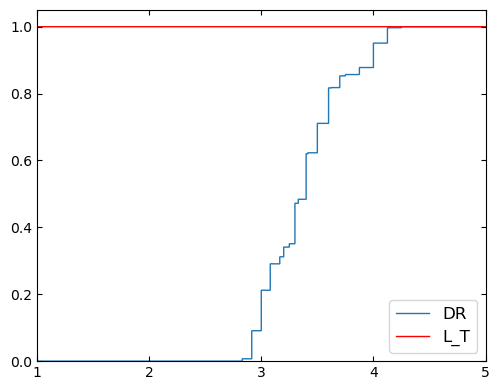

In [70]:
plpi=performance_plot(Rlist([DR[2],LT[2]],[DR[4],LT[4]],1000), .005,5)

In [49]:
print("DR average iterates",np.average(DR[2]),"LT average iterates",np.average(LT[2]), "LToPA average iterates",np.average(PLT[2]) )

DR average iterates 34.74 LT average iterates 10.378 LToPA average iterates 8.974


Performance profile for cpu time

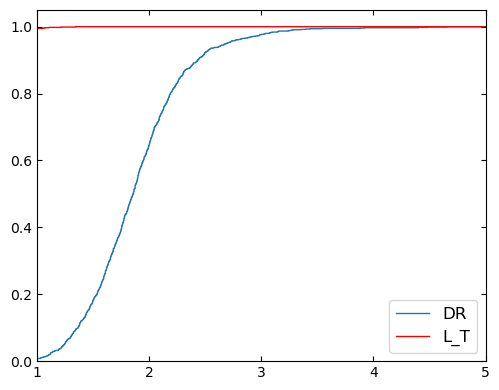

In [71]:
plpi=performance_plot(Rlist([DR[3],LT[3]],[DR[4],LT[4]],1000), .005,5)

In [33]:
print("DR average iterates",np.average(DR[3]),"LT average iterates",np.average(LT[3]), "LToPA average iterates",np.average(PLT[3]) )

DR average iterates 0.004264926799660316 LT average iterates 0.0023423984000401107 LToPA average iterates 0.002108355100164772


In [113]:
av_i=[]
for x in np.arange(1000):
    average = (PLT[2][x]+LT[2][x])/2
    av_i.append(average)

np.argmin(av_i)

np.int64(237)

In [114]:
choose = 237

x0 = Zi_list[choose]
x0,DR[2][choose],LT[2][choose],PLT[2][choose]

(array([[Decimal('0.8804193787095347')],
        [Decimal('0.5015297237727039')]], dtype=object),
 28,
 6,
 6)

In [115]:
x0 = np.array([[Decimal('0.7')],[Decimal('0.7')]])
#Douglas_rachford_circle_line(x0,100)

In [38]:
def calculate_log_norms(iterates):
    """
    Calculate log norms of iterates with respect to the final iterate using mpmath.
    
    Parameters
    ----------
    iterates : list of mp.matrix
        Sequence of iterates (all the same shape, typically 2x1).
    
    Returns
    -------
    list of mp.mpf
        Logarithms of the Euclidean norms ||x - x_final||.
    """
    final_iterate = iterates[-1]
    norms = []
    for iterate in iterates[:-1]:
        diff = iterate - final_iterate
        # flatten diff into a list of entries and compute 2-norm
        v = [diff[i,0] for i in range(diff.rows)]
        norm = mp_norm(v)
        norms.append(mp.log(norm))
    return norms
set_precision(1000)
x0=Zi_list[2]
x0 = mp.matrix([[mp.mpf('0.7')], [mp.mpf('0.7')]])
runs = 8
iterates_set1 = Douglas_rachford(x0, runs, order="line-circle",ignore_tol=True)[3]
iterates_set2 = LSM(x0, runs,order="line-circle",ignore_tol=True)[3]
iterates_set3 = PLSM(x0, runs,order="line-circle",ignore_tol=True)[3]

log_norms_set1 = calculate_log_norms(iterates_set1)
log_norms_set2 = calculate_log_norms(iterates_set2)
log_norms_set3 = calculate_log_norms(iterates_set3)


denominator is: 0.0004615018009373435246970564794450981043544284629446715953635886560977403436981305815990882956654242641120587464317031907572096434764789252344563746369473089043146667207804487659404817799741449418709354897134279946955348616951855507667042071816032575683268587818148282010032297833061909088320150288048397010804093301904683729581584024180202604777797132983930322995077921067602607782724478480647728024298127431865975373013446605729232474902606022026762505450446962798764557993289348161675628262729502782450182871562014028842563286087549381857610924528030809062590367920800959007473929260787342014920782481975740586068344456871727546427244080138982756326529263988252442592623197035924192304317448069209449578341048600894578905946850475537161241500616771709868489216778868018213490528078331440696439864780792735891019961778815516020694285434466178623548525356510656408763203058508535788181044442133521053251870578092889394729084778247563533590843566431447641368125630648682178665870768

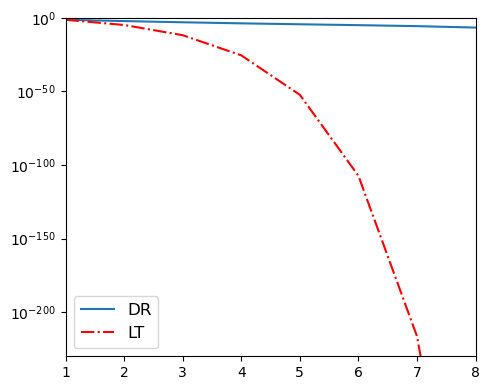

In [87]:

# Plotting
plt.figure(figsize=(5, 4))
plt.plot(range(1, len(log_norms_set1) + 1), [float(norm) for norm in log_norms_set1], label='DR')
plt.plot(range(1, len(log_norms_set2) + 1), [float(norm) for norm in log_norms_set2], label='LT', linestyle='-.', color='red')
#plt.plot(range(1, len(log_norms_set3) + 1), [float(norm) for norm in log_norms_set3], label='LToPA', linestyle='--', color='orange')


plt.grid(False)
plt.ylim(-230, 0)
plt.xlim(1, len(log_norms_set1))

# Set y-ticks as powers of 10
ax = plt.gca()
plt.tick_params(axis='both', labelsize=10)
ax.set_yticks([-200, -150, -100, -50, 0])
ax.set_yticklabels([r'$10^{-200}$', r'$10^{-150}$', r'$10^{-100}$', r'$10^{-50}$', r'$10^{0}$'])

#plt.xlabel('Iteration')
#plt.ylabel(r'$\log \|x_k - \bar{x}\|$')
plt.legend(
    loc='lower left',
    ncol=1,
    fontsize=12,
    frameon=True
)

plt.tight_layout()  # Adjust layout to make space for legend
plt.savefig('convergence_plot.pdf', bbox_inches='tight')
plt.show()

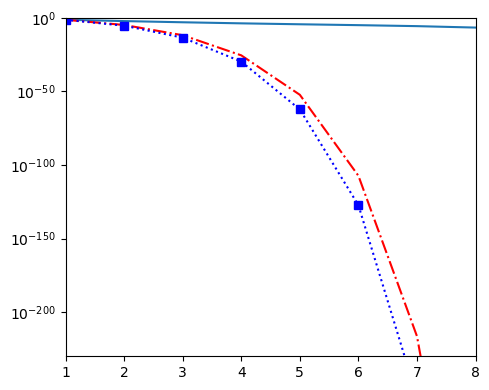

In [74]:

# Plotting
plt.figure(figsize=(5, 4))
plt.plot(range(1, len(log_norms_set1) + 1), [float(norm) for norm in log_norms_set1], label='DR')
plt.plot(range(1, len(log_norms_set2) + 1), [float(norm) for norm in log_norms_set2], label='LT', linestyle='-.', color='red')
plt.plot(range(1, len(log_norms_set3) + 1), [float(norm) for norm in log_norms_set3], label='LToPA', linestyle=':', marker='s', color='blue')


plt.grid(False)
plt.ylim(-230, 0)
plt.xlim(1, len(log_norms_set1))

# Set y-ticks as powers of 10
ax = plt.gca()
ax.set_yticks([-200, -150, -100, -50, 0])
ax.set_yticklabels([r'$10^{-200}$', r'$10^{-150}$', r'$10^{-100}$', r'$10^{-50}$', r'$10^{0}$'])

#plt.xlabel('Iteration')
#plt.ylabel(r'$\log \|x_k - \bar{x}\|$')
# plt.legend(
#     loc='upper center',
#     bbox_to_anchor=(0.5, -0.1),
#     ncol=2,
#     fontsize=12
# )

plt.tight_layout()  # Adjust layout to make space for legend
plt.savefig('convergence_plot.png', bbox_inches='tight')
plt.show()

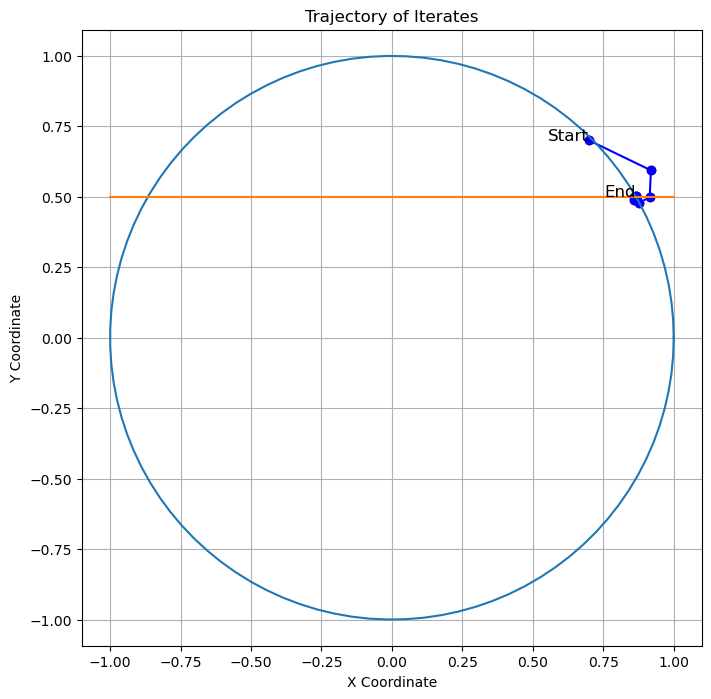

denominator is: 0.0004615018009373435246970564794450981043544284629446715953635886560977403436981305815990882956654242641120587464317031907572096434764789252344563746369473089043146667207804487659404817799741449418709354897134279946955348616951855507667042071816032575683268587818148282010032297833061909088320150288048397010804093301904683729581584024180202604777797132983930322995077921067602607782724478480647728024298127431865975373013446605729232474902606022026762505450446962798764557993289348161675628262729502782450182871562014028842563286087549381857610924528030809062590367920800959007473929260787342014920782481975740586068344456871727546427244080138982756326529263988252442592623197035924192304317448069209449578341048600894578905946850475537161241500616771709868489216778868018213490528078331440696439864780792735891019961778815516020694285434466178623548525356510656408763203058508535788181044442133521053251870578092889394729084778247563533590843566431447641368125630648682178665870768

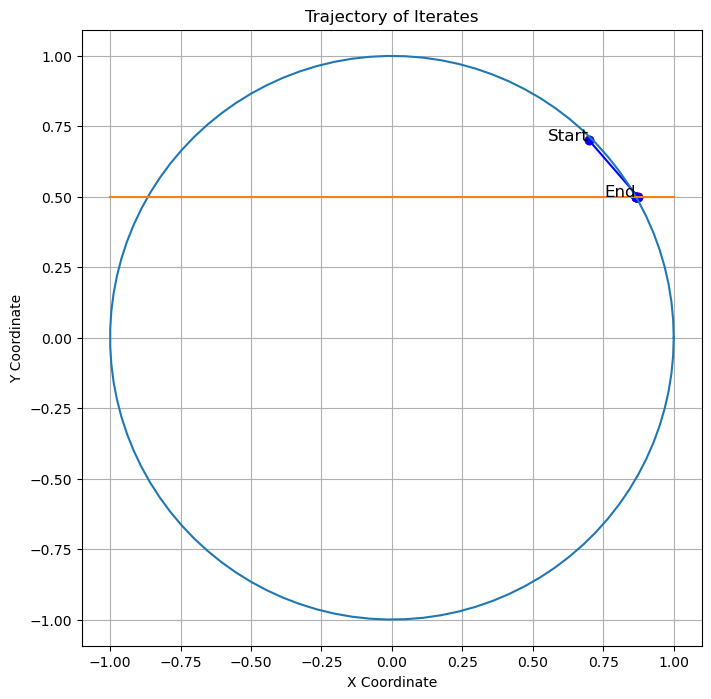

In [76]:
def plot_iterates(iterates, start_from=0):
    # Slice the iterates starting from the specified index
    iterates = iterates[start_from:]
    x_coords = [float(iterate[0, 0]) for iterate in iterates]
    y_coords = [float(iterate[1, 0]) for iterate in iterates]
    
    plt.figure(figsize=(8, 8))
    plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='blue')
    plt.scatter(x_coords, y_coords, color='red')

    theta = np.linspace(0, 2*np.pi, 100)  # 100 points evenly spaced from 0 to 2*pi

    # Calculate x and y values for the circle using polar coordinates
    x_circle = np.cos(theta)
    y_circle = np.sin(theta)
    
    # Plot the circle
    plt.plot(x_circle, y_circle, label='Circle: x1^2 + x2^2 = 1')
    
    # Plot the line y = sqrt(2)/2
    x_line = np.linspace(-1, 1, 100)
    y_line = 1/2 * np.ones_like(x_line)
    plt.plot(x_line, y_line, label='Line: y = sqrt(2)/2')
    
    plt.text(x_coords[0], y_coords[0], 'Start', fontsize=12, ha='right')
    plt.text(x_coords[-1], y_coords[-1], 'End', fontsize=12, ha='right')
    
    plt.grid(True)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Trajectory of Iterates')
    plt.axis('equal')
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
    plt.show()

# Call the function specifying to start from the second iterate
plot_iterates(Douglas_rachford(x0,15)[3])
plot_iterates(LSM(x0,15)[3])
